# Model building

In [2]:
#reset

## Load packages and dataset

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
import time
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import statsmodels.api as sm
from statsmodels.api import add_constant
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import datasets, linear_model




In [4]:
df = pd.read_csv('model_Data_17_Nov.csv')
pd.set_option('display.max_columns', None)




* ### Make sure categorcal

In [5]:
print('df : ' + str(df.dtypes.value_counts()))

df : int64      47
float64    41
object     14
dtype: int64


In [6]:
#We make sure that the objects become category again. 
categoryAgain = list(df.select_dtypes(include=['object']))


#We make sure that our category variables are given the dtype, after we have loaded our dataset.
for category in categoryAgain:
    df[category] = df[category].astype('category')

* ### Ordinal variables

In [7]:
ordered_Energy = ['G', 'F', 'E', 'D' , 'C', 'B','A']#['A', 'B', 'C', 'D', 'E', 'F', 'G']
ordered_RadonRisk = ['Meget lav', 'lav', 'medium', 'høj']
ordered_NoiseLvl = ['Ingen trafikstøj', '55-60 dB','60-65 dB','65-70 dB','over 70 dB']
ordered_FloodRisk = ['er lav risiko', 'kan være risiko', 'er høj risiko']
ordered_BurglaryRisk = ['lav', 'mellem', 'høj']
ordered_ConservationValue = ['Ingen bevaringsværdi', 'Lav bevaringsværdi', 'Middel bevaringsværdi', 'Høj bevaringsværdi']



In [8]:
df['energy_label_classification'] = df['energy_label_classification'].cat.set_categories(ordered_Energy, ordered = True)
df['radonRisk'] = df['radonRisk'].cat.set_categories(ordered_RadonRisk, ordered = True)
df['noiseLvl'] = df['noiseLvl'].cat.set_categories(ordered_NoiseLvl, ordered = True)
df['floodRisk'] = df['floodRisk'].cat.set_categories(ordered_FloodRisk, ordered = True)
df['burglaryRisk'] = df['burglaryRisk'].cat.set_categories(ordered_BurglaryRisk, ordered = True)
df['conservationValue'] = df['conservationValue'].cat.set_categories(ordered_ConservationValue, ordered = True)


In [9]:
map_Energy = {'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1}
map_RadonRisk = {'Meget lav':1, 'lav':2, 'medium':3, 'høj':4}
map_NoiseLvl = {'Ingen trafikstøj':1, '55-60 dB':2, '60-65 dB':3, '65-70 dB':4, 'over 70 dB':5}
map_FloodRisk = {'er lav risiko':1, 'kan være risiko':2, 'er høj risiko':3}
map_BurglaryRisk = {'lav':1, 'mellem':2, 'høj':3}
map_ConservationValue = {'Ingen bevaringsværdi':1, 'Lav bevaringsværdi':2, 'Middel bevaringsværdi':3, 'Høj bevaringsværdi':4}

In [10]:
df['energy_label_classification'] = df['energy_label_classification'].map(map_Energy)
df['radonRisk'] = df['radonRisk'].map(map_RadonRisk)
df['noiseLvl'] = df['noiseLvl'].map(map_NoiseLvl)
df['floodRisk'] = df['floodRisk'].map(map_FloodRisk)
df['burglaryRisk'] = df['burglaryRisk'].map(map_BurglaryRisk)
df['conservationValue'] = df['conservationValue'].map(map_ConservationValue)

## Models


### Functions

In [11]:
def resetIndexFor_df(df_input): 
    df_input_copy = df_input.copy()
    df_input_copy.reset_index(inplace=True)
    df_input_copy.drop(columns='index', inplace=True)
    return df_input_copy

In [12]:
def OLS(dataframe, target, DontUseVariables, log):
    
    df_copy = dataframe.copy() #We take a copy of the df. 

   
    #We remove the different price variable in our datase, so we dont need to make two DontUseVariables lists.   
    if target=='sold_price':
        df_copy.drop(columns=['m2Price_WA'], inplace=True)
    elif target=='m2Price_WA':
        df_copy.drop(columns=['sold_price', 'weighted_area'], inplace=True)
    else:
        pass


    #We drop the variables we dont need in our X variable
    X = df_copy.drop(columns=(DontUseVariables + [target])) 
    y = df_copy[target]





    if log=='Yes':

        #We prepare for LOG Tranformation name variable. 
        target_ln = target + '_ln' #We create our new variable name
        # We create our new variable where we use the natural log (ln).
        df_copy[target_ln] = np.log(df_copy[target]) 


        
        X = df_copy.drop(columns=(DontUseVariables + [target, target_ln])) #We overwrite X, were we also drop the new column of our log(target)
        y = df_copy[target_ln] #overwrite y if we are using our new target which is log transformation 

    X, y = shuffle(X, y, random_state=2)


    pipe = Pipeline([('scaler', StandardScaler()),('regressor', LinearRegression())])

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)


    train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes = np.linspace(0.1, 1.0, 20), cv=5, n_jobs=1)

    
    #We fit our model on the traning data
    pipe = pipe.fit(X_train, y_train)



    #We take out the coefficents and save the in a dataframe
    feature_names = np.array(X.columns) #We name them correctly

    #First we take our intercept:
    intercept = pd.DataFrame(pipe.named_steps['regressor'].intercept_, columns=['Coefficients'], index=['Intercept'])
    #We now get our coefficients
    coefs = pd.DataFrame(pipe.named_steps['regressor'].coef_, columns=['Coefficients'], index=feature_names)
    #And then we append them
    coefs = pd.concat([intercept, coefs])#intercept.append(coefs)

    #We then predict on both our training and test dataset:
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)


    

    #We gather the data in a pandas dataframe
    Train_data = pd.DataFrame({'Predicted': y_train_pred, 'True': y_train, 'Residuals':(y_train_pred - y_train), 'Data': 'Training data'})
    Test_data = pd.DataFrame({'Predicted': y_test_pred, 'True': y_test, 'Residuals':(y_test_pred - y_test), 'Data': 'Test data'})
    #We store it toghether in one df. 
    Train_and_Test_data = pd.concat([Train_data, Test_data])

    #We also gather the train and test set, so we can use this to show some results later
    y_TRAIN = resetIndexFor_df(pd.DataFrame({'y': y_train, 'Data': 'Training data'}))
    X_TRAIN = resetIndexFor_df(X_train)

    y_TEST = resetIndexFor_df(pd.DataFrame({'y': y_test, 'Data': 'Test data'}))
    X_TEST = resetIndexFor_df(X_test)

    Xy_train = pd.concat([X_TRAIN, y_TRAIN], axis=1)
    Xy_test = pd.concat([X_TEST, y_TEST], axis=1)

    #We store it toghether in one df. 
    Xy = resetIndexFor_df(pd.concat([Xy_train, Xy_test]))


    return Train_and_Test_data, pipe, Xy, train_sizes, train_scores, test_scores, coefs


In [13]:
def OLS_plot(OLS_df, target, ln):

    fig = plt.figure(figsize = (14, 6))

    ax = plt.subplot(1,2,1)

    sns.scatterplot(data=OLS_df, x='Predicted', y='Residuals', hue= 'Data')
    mini = round((OLS_df['Predicted'].min()-1 ), 1)
    maxi = round((OLS_df['Predicted'].max()+1 ), 1)
    X_plot = np.linspace(mini, maxi, 10)
    Y_plot = np.linspace(0, 0, 10)
    plt.plot(X_plot, Y_plot, color='black', ls='--')


    ax = plt.subplot(1,2,2)

    sns.scatterplot(data=OLS_df, x='True', y='Predicted', hue= 'Data')


    mini = round((min(OLS_df['True'].min(), OLS_df['Predicted'].min())-1 ), 1)

    maxi = round((max(OLS_df['True'].max(), OLS_df['Predicted'].max())+1 ), 1)


    X_plot = np.linspace(mini, maxi, 10)
    Y_plot = np.linspace(mini, maxi, 10)
    plt.xlim([mini, maxi])
    plt.ylim([mini, maxi])
    plt.plot(X_plot, Y_plot, color='r', ls='--')


    plt.title('')

    if ln =='No':
        fig.suptitle(target)
        
        print(target)
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/OLS Residuals ' + target + '.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/OLS Residuals ' + target + '.png', bbox_inches='tight')
    elif ln == 'Yes':
        fig.suptitle('LOG(' + target + ')')
        
        print('LOGTRANSFORMED : LOG(' + target + ')')
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/OLS Residuals LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/OLS Residuals LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
    else:
        pass

    plt.show()

In [14]:
def OLS_QQ_plot(OLS_df, target, ln):


    Train = OLS_df.loc[OLS_df['Data']=='Training data']
    Test  = OLS_df.loc[~(OLS_df['Data']=='Training data')]

    fig = plt.figure(figsize = (14, 6))

    ax = plt.subplot(1,2,1)


    stats.probplot(Train['Residuals'], dist=norm, plot=plt, fit=True)
    ax.get_lines()[0].set_markerfacecolor('White')
    ax.get_lines()[0].set_markeredgecolor('blue')
    plt.title("Training data")

    ax = plt.subplot(1,2,2)

    stats.probplot(Test['Residuals'], dist=norm, plot=plt, fit=True)
    ax.get_lines()[0].set_markerfacecolor('White')
    ax.get_lines()[0].set_markeredgecolor('orange')
    plt.title("Test data")

    if ln =='No':
        fig.suptitle('Normal Q-Q Plot for ' + target )
        print(target)
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/OLS QQ-plot ' + target + '.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/OLS QQ-plot ' + target + '.png', bbox_inches='tight')
    elif ln == 'Yes':
        fig.suptitle('Normal Q-Q Plot for LOG(' + target + ')')
        print('LOGTRANSFORMED : LOG(' + target + ')')
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/OLS QQ-plot LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/OLS QQ-plot LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
    else:
        pass


    plt.show()

In [15]:
#####################################################
#### Learning Curve with 5-fold Cross-validation ####
#####################################################

def plotLearningCurve(train_sizes, train_scores, test_scores, target, ln):

    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Trainning score')

    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='orange', linestyle='--', marker='s', markersize=5, label='Cross-validation score')

    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='orange')

    plt.grid()
    plt.xlabel('Number of observations used in traning')
    plt.ylabel('Score($R^2$)')
    plt.legend(loc='lower right')
    plt.ylim([round((test_mean.max()-0.01), 3) , round((train_mean.max()+0.01), 3)])
    plt.legend(loc='upper left')
    
    if ln =='No':
        print(target)
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/Learning curve for ' + target + '.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/Learning curve for ' + target + '.png', bbox_inches='tight')
    elif ln == 'Yes':
        print('LOGTRANSFORMED : LOG(' + target + ')')
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/Learning curve for LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/Learning curve for LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
    else:
        pass

    plt.show()


In [16]:
###################################
### MOST IMPORTANT COEFFICIENTS ###
###################################


def Coefs_And_Plot(coefs_, target, ln):
    coefs = coefs_.copy()
    
    #We order by its values, and take out the 8 highest and lowest values
    imp_coef = pd.concat([coefs.sort_values(by=['Coefficients']).head(8), coefs.sort_values(by=['Coefficients']).tail(8)])
    imp_coef.drop('Intercept', inplace = True)
    #We choose our colors for the neagtive and positive values:
    color = ['deepskyblue' if y<0 else 'coral' for y in imp_coef['Coefficients']]
    #We then plot:
    fig, ax1 = plt.subplots(figsize = (10, 4))
    ax1.barh(imp_coef.index, imp_coef['Coefficients'], color = color)
    

    plt.yticks(rotation = 25)

    #We color the negative Coefficients label names as the same color: deepskyblue
    ticklabels = [t for t in plt.gca().get_yticklabels()]
    for l in list(imp_coef.index[0:8]):
        i = list(imp_coef.index).index(l)
        ticklabels[i].set_color("deepskyblue")
        ticklabels[i].set_fontweight("bold")
    #We color the positive Coefficients label names as the same color: coral
    ticklabels = [t for t in plt.gca().get_yticklabels()]
    for l in list(imp_coef.index[8:]):
        i = list(imp_coef.index).index(l)
        ticklabels[i].set_color("coral")
        ticklabels[i].set_fontweight("bold")


    if ln =='No':
        plt.title('OLS Coefficients for ' + target ,fontweight="bold")
        print(target)
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/Coefs highest values for ' + target + '.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/Coefs highest values for ' + target + '.png', bbox_inches='tight')
    elif ln == 'Yes':
        plt.title('OLS Coefficients for LOG(' + target + ')' ,fontweight="bold")
        
        print('LOGTRANSFORMED : LOG(' + target + ')')
        #plt.savefig('C:/Users/Mtubo/Desktop/Uni/Kandidat/Thesis/Kode/Figures' + '/Coefs highest values for LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
        #plt.savefig('C:/Users/Mtubo/Dropbox/Apps/Overleaf/Thesis 2022/Figures' + '/Coefs highest values for LOGTRANSFORMED ' + target + '_ln.png', bbox_inches='tight')
    else:
        pass

    plt.show()

    
    

In [17]:


def results1(OLS_data):

    y_train_pred = OLS_data.loc[OLS_data['Data']=='Training data']['Predicted'] #Traning set predicted
    y_test_pred = OLS_data.loc[~(OLS_data['Data']=='Training data')]['Predicted'] #Test set predicted
    y_train = OLS_data.loc[OLS_data['Data']=='Training data']['True'] #Traning set true
    y_test = OLS_data.loc[~(OLS_data['Data']=='Training data')]['True'] #Test set true

    res = pd.DataFrame({'MSE, train' : [(mean_squared_error(y_train, y_train_pred))],
                            'MSE, test' : (mean_squared_error(y_test, y_test_pred)),
                            'MAE, train' : (mean_absolute_error(y_train, y_train_pred)),
                            'MAE, test' : (mean_absolute_error(y_test, y_test_pred)),
                            '$R^2$, train' : (r2_score(y_train, y_train_pred)),
                            '$R^2$, test' : (r2_score(y_test, y_test_pred))},
                            index = ['OLS'])

    print(res.to_latex(index=True))
    return res

In [18]:


def result2(OLS_data, ln):

    df = OLS_data.copy()
    
    #We only want the data from the Test set:
    df = df.loc[df['Data']=='Test data']
   
    if ln=='Yes':

        df['exp_y_pred'] = np.exp(df['Predicted'])
        df['exp_y_test'] = np.exp(df['True'])
        df['difference'] = abs(df['exp_y_test']-df['exp_y_pred'])
        df['diffpercent'] = (df['difference'] / df['exp_y_test']) *100
        
    elif ln=='No':

        df['difference'] = abs(df['True']-df['Predicted'])
        df['diffpercent'] = (df['difference'] / df['True']) *100

    else:
        pass


    mean_percent = np.mean(df['diffpercent'])
    median_percent = np.median(df['diffpercent'])
    within10 = (len(df[df['diffpercent'] < 10]) / len(df)) *100
    within15 = (len(df[df['diffpercent'] < 15]) / len(df)) *100
    within20 = (len(df[df['diffpercent'] < 20]) / len(df)) *100

    res = pd.DataFrame({'Mean deviation %' : [mean_percent],
                        'Median deviation %' : [median_percent],
                        'Within 10 %': [within10],
                        'Within 15 %': [within15],
                        'Within 20 %': [within20]},
                        index = ['OLS'] )

    print(res.round(2).to_latex(index=True))

### Run our functions with our models

In [19]:
#We delete alle the variables we will not use when modelling.
#We cant use year_renovated because of the missing values, so we also drop this. 

#Remeber it will automatically drop our target, so we dont have to do this here. 
DontUseVar  = ['AVM_price', 'latest_prop_valuation', 'Year_Week', 'Year_Months', 'Year_Quarter', 'addressName', 'addressNumber', 'addressDoor', 'address_id', 'saleDate', 'saleYear']


In [20]:
###########################################################
############### OLS data results ##########################
###########################################################
OLS_sold_price, pipe_sold_price, Xy_sold_price, train_sizes_sold_price, train_scores_sold_price, test_scores_sold_price, coefs_sold_price = OLS(df, 'sold_price', DontUseVar, 'No')
OLS_sold_price_ln, pipe_sold_price_ln, Xy_sold_price_ln, train_sizes_sold_price_ln, train_scores_sold_price_ln, test_scores_sold_price_ln, coefs_sold_price_ln = OLS(df, 'sold_price', DontUseVar, 'Yes')

OLS_m2Price, pipe_m2Price, Xy_m2Price, train_sizes_m2Price, train_scores_m2Price, test_scores_m2Price, coefs_m2Price = OLS(df, 'm2Price_WA', DontUseVar, 'No')
OLS_m2Price_ln, pipe_m2Price_ln, Xy_m2Price_ln, train_sizes_m2Price_ln, train_scores_m2Price_ln, test_scores_m2Price_ln, coefs_m2Price_ln = OLS(df, 'm2Price_WA', DontUseVar, 'Yes')


sold_price


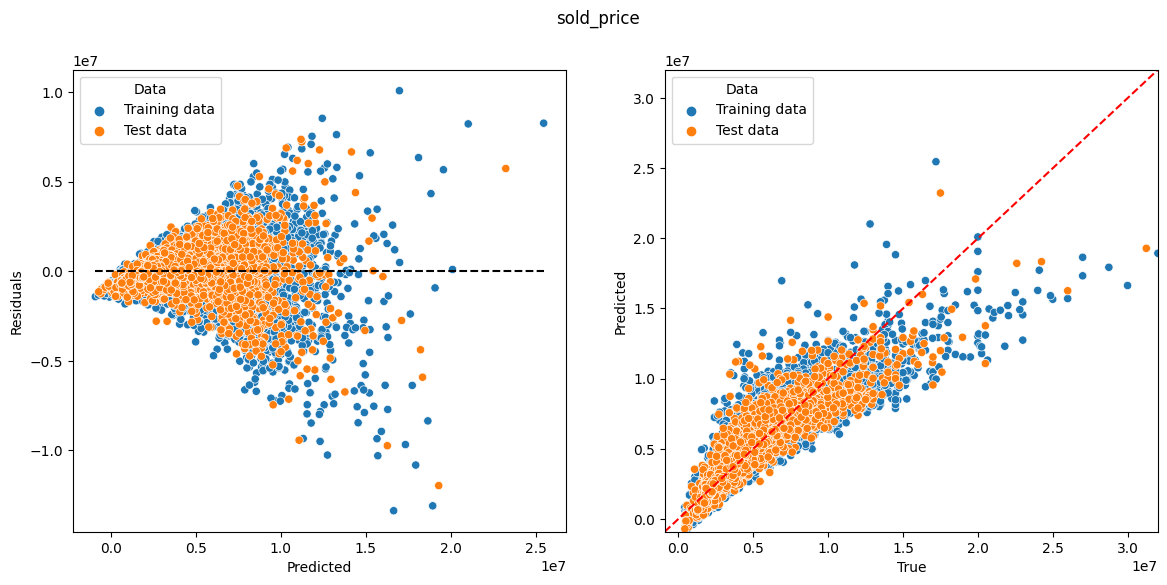

LOGTRANSFORMED : LOG(sold_price)


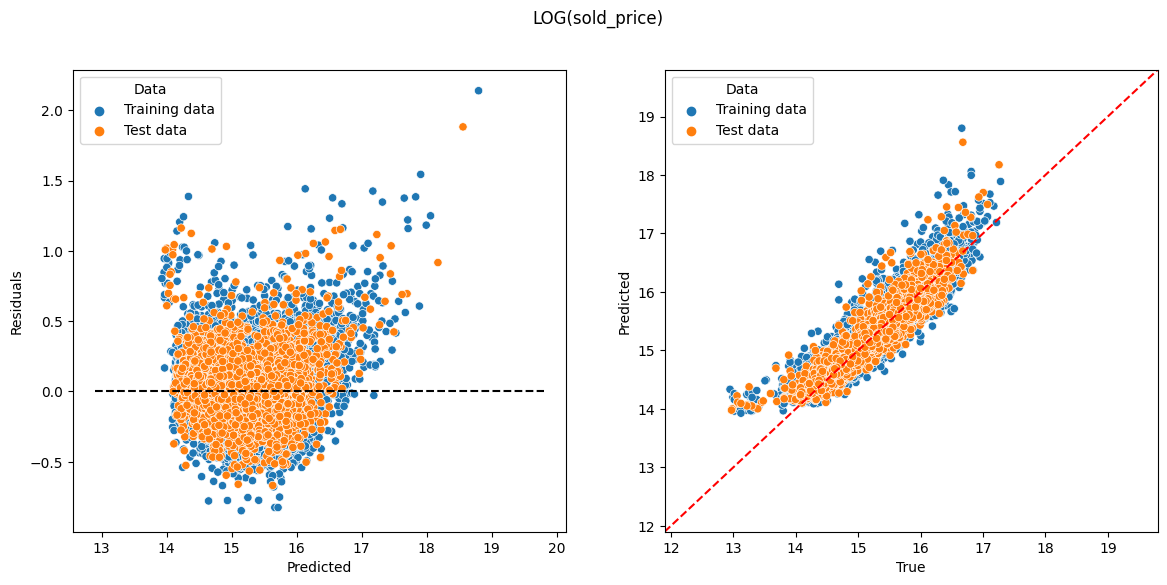

m2Price_WA


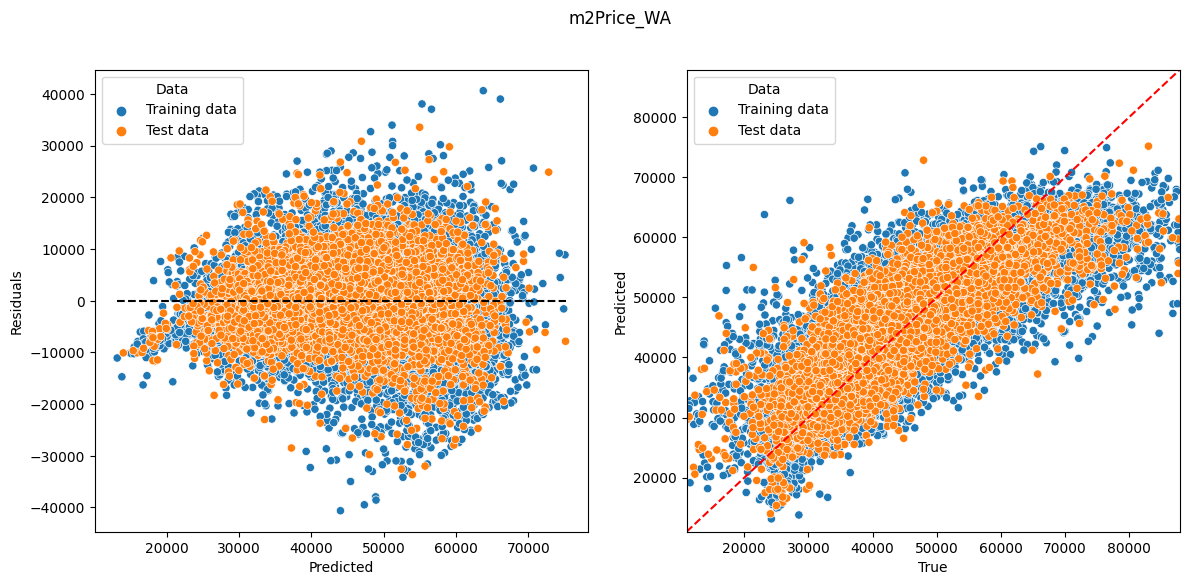

LOGTRANSFORMED : LOG(m2Price_WA)


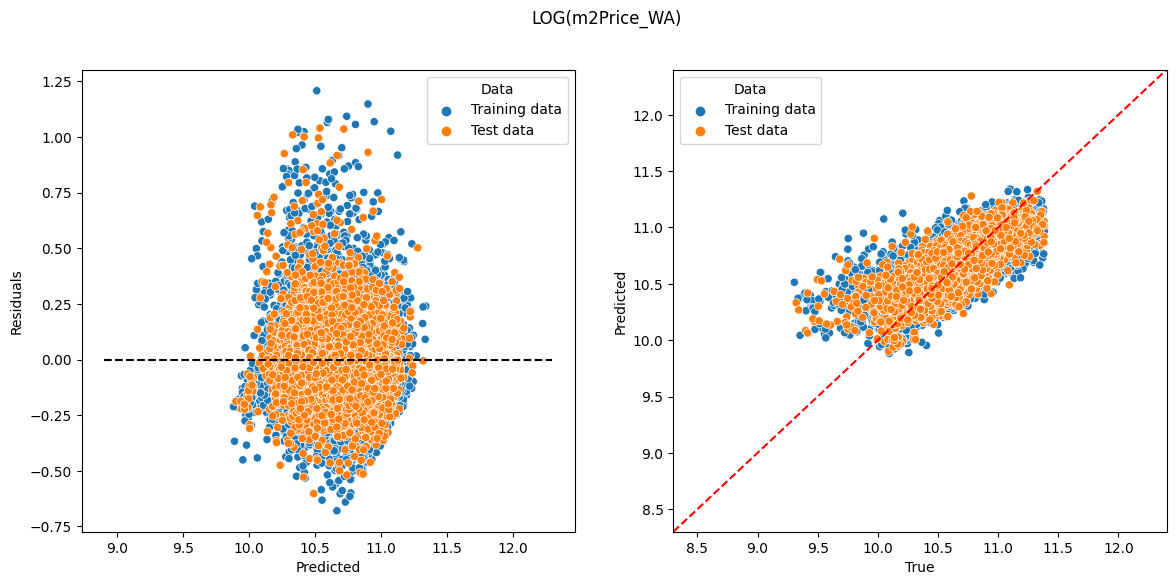

In [21]:
###########################################################
############### OLS plot results ##########################
###########################################################

OLS_plot(OLS_sold_price, 'sold_price', 'No')
OLS_plot(OLS_sold_price_ln, 'sold_price', 'Yes')

OLS_plot(OLS_m2Price, 'm2Price_WA', 'No')
OLS_plot(OLS_m2Price_ln, 'm2Price_WA', 'Yes')

sold_price


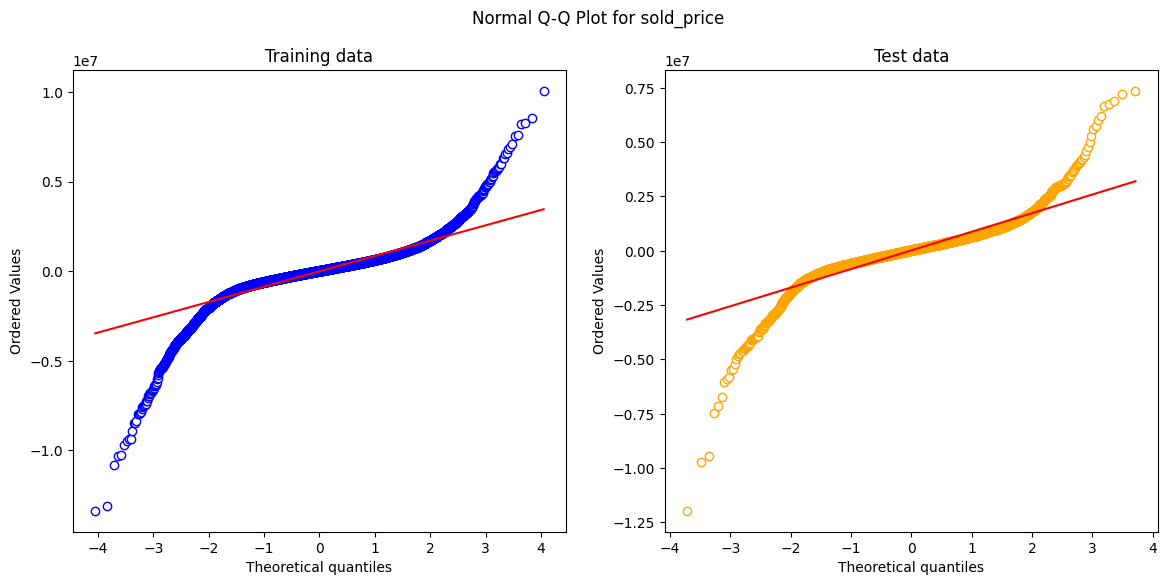

LOGTRANSFORMED : LOG(sold_price)


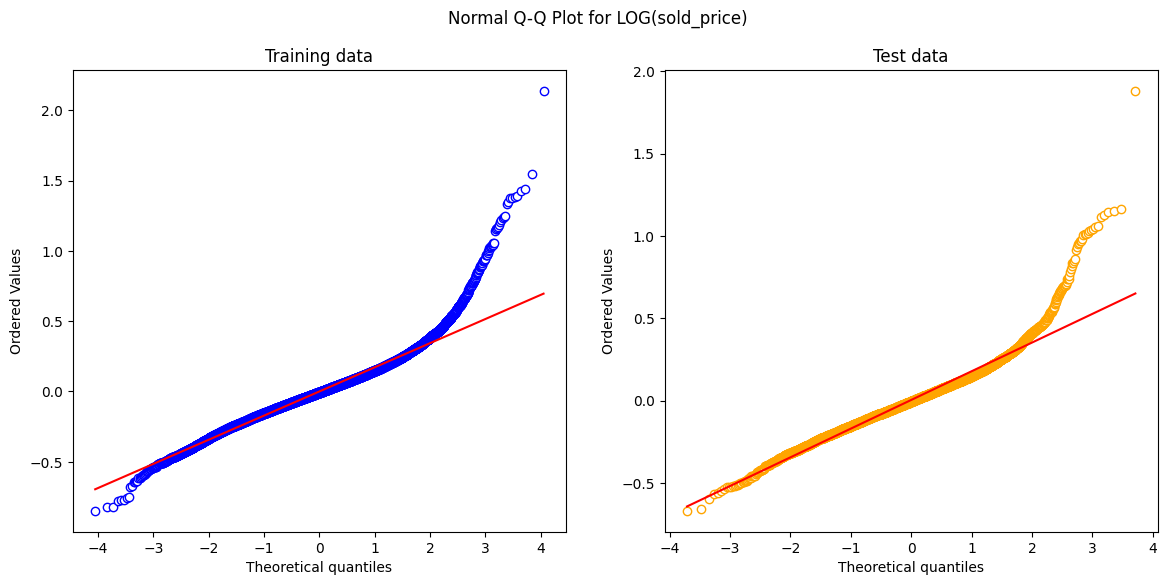

m2Price_WA


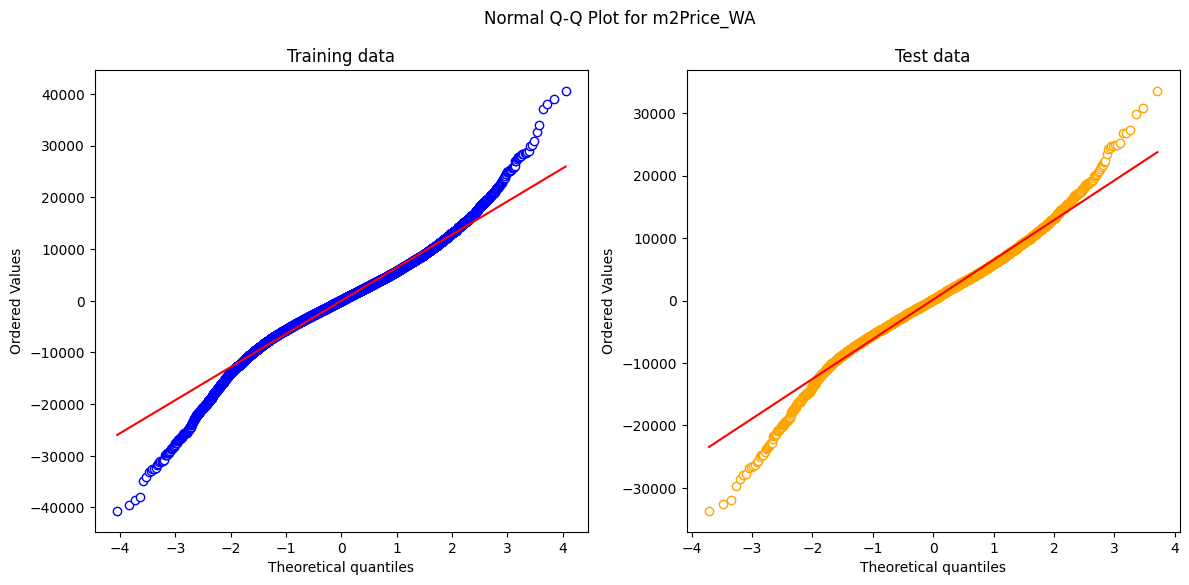

LOGTRANSFORMED : LOG(m2Price_WA)


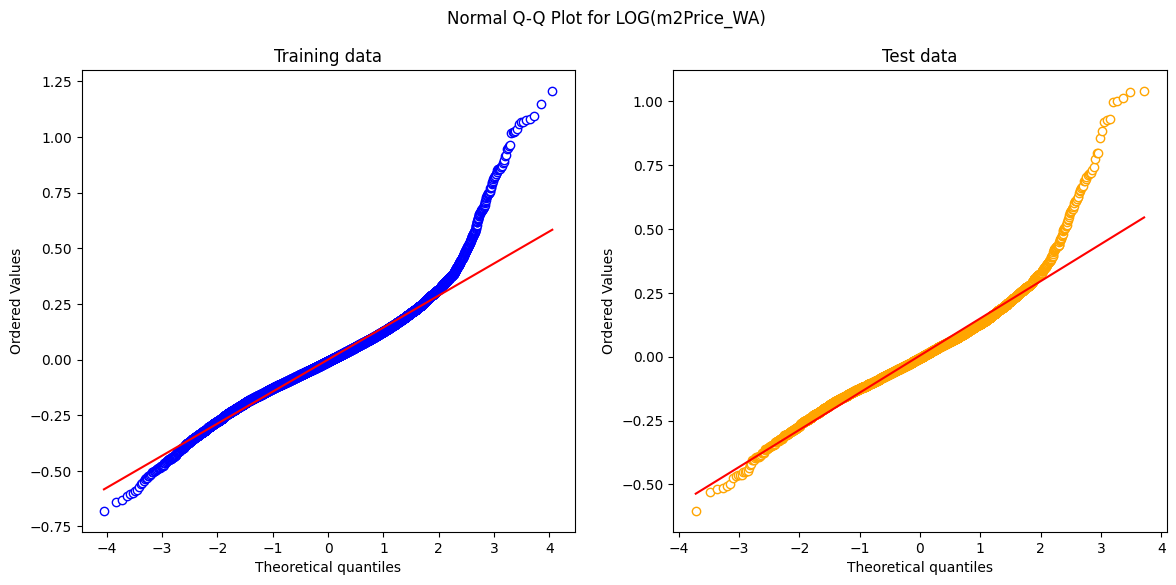

In [22]:
###########################################################
############### OLS QQ-plot results #######################
###########################################################

OLS_QQ_plot(OLS_sold_price, 'sold_price', 'No')
OLS_QQ_plot(OLS_sold_price_ln, 'sold_price', 'Yes')

OLS_QQ_plot(OLS_m2Price, 'm2Price_WA', 'No')
OLS_QQ_plot(OLS_m2Price_ln, 'm2Price_WA', 'Yes')

sold_price


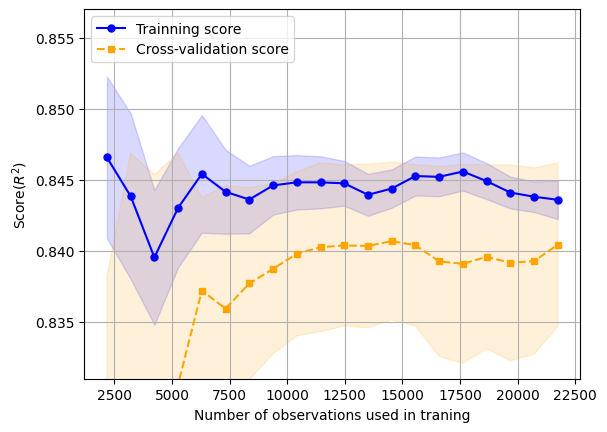

LOGTRANSFORMED : LOG(sold_price)


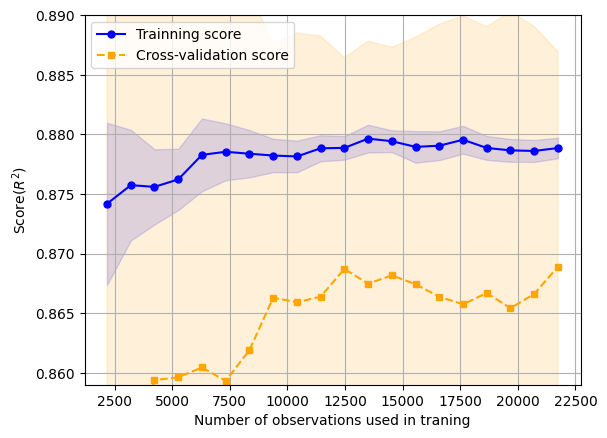

m2Price_WA


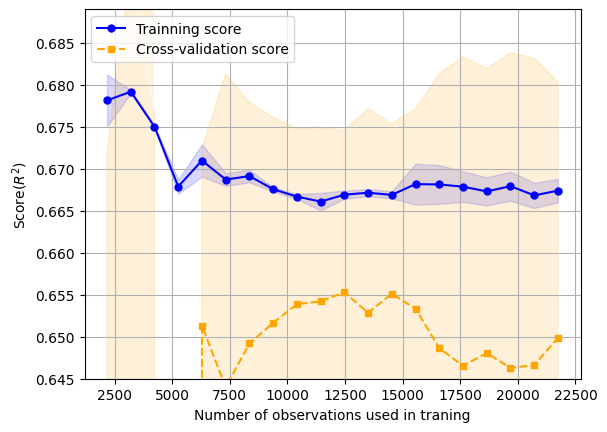

LOGTRANSFORMED : LOG(m2Price_WA)


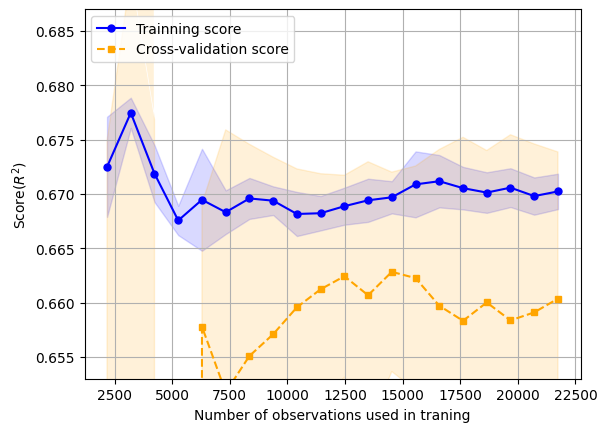

In [23]:
#####################################################
#### Learning Curve with 5-fold Cross-validation ####
#####################################################

plotLearningCurve(train_sizes_sold_price, train_scores_sold_price, test_scores_sold_price, 'sold_price', 'No')
plotLearningCurve(train_sizes_sold_price_ln, train_scores_sold_price_ln, test_scores_sold_price_ln, 'sold_price', 'Yes')

plotLearningCurve(train_sizes_m2Price, train_scores_m2Price, test_scores_m2Price, 'm2Price_WA', 'No')
plotLearningCurve(train_sizes_m2Price_ln, train_scores_m2Price_ln, test_scores_m2Price_ln, 'm2Price_WA', 'Yes')

In [24]:
##################
### ASSESSMENT ###
##################


Results_sold_price_ln = results1(OLS_sold_price_ln)
Results_sold_price_ln

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
OLS &    0.030801 &   0.032163 &     0.12924 &   0.130592 &      0.878704 &      0.87406 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_3540\3041227762.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
OLS,0.030801,0.032163,0.12924,0.130592,0.878704,0.87406


In [25]:
Results_m2Price_ln = results1(OLS_m2Price_ln)
Results_m2Price_ln

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MSE, test &  MAE, train &  MAE, test &  \$R\textasciicircum 2\$, train &  \$R\textasciicircum 2\$, test \\
\midrule
OLS &    0.021563 &   0.022216 &    0.108979 &   0.109713 &      0.669906 &     0.666798 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_3540\3041227762.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(index=True))


,"MSE, train","MSE, test","MAE, train","MAE, test","$R^2$, train","$R^2$, test"
OLS,0.021563,0.022216,0.108979,0.109713,0.669906,0.666798


In [26]:

result2(OLS_sold_price_ln,'Yes')

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
OLS &             13.67 &                10.0 &        50.01 &        68.37 &         81.0 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_3540\2926718094.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


In [27]:
result2(OLS_m2Price_ln,'Yes')

\begin{tabular}{lrrrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 10 \% &  Within 15 \% &  Within 20 \% \\
\midrule
OLS &             11.34 &                 8.5 &        57.19 &        76.38 &        86.15 \\
\bottomrule
\end{tabular}



C:\Users\Mtubo\AppData\Local\Temp\ipykernel_3540\2926718094.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.round(2).to_latex(index=True))


sold_price


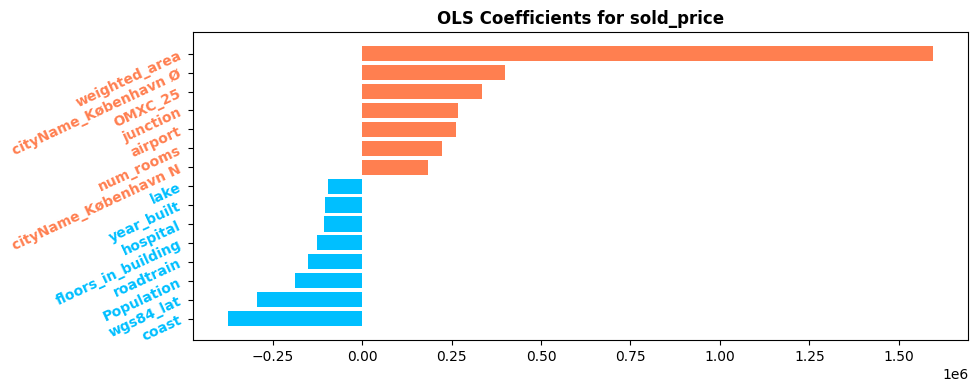

LOGTRANSFORMED : LOG(sold_price)


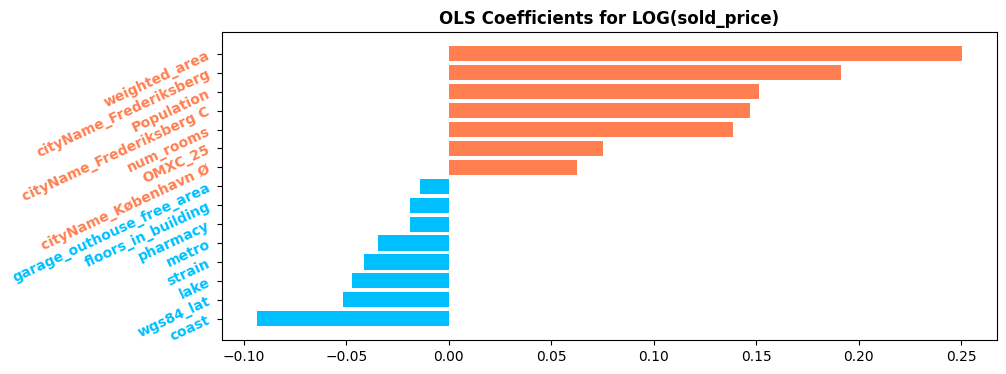

m2Price_WA


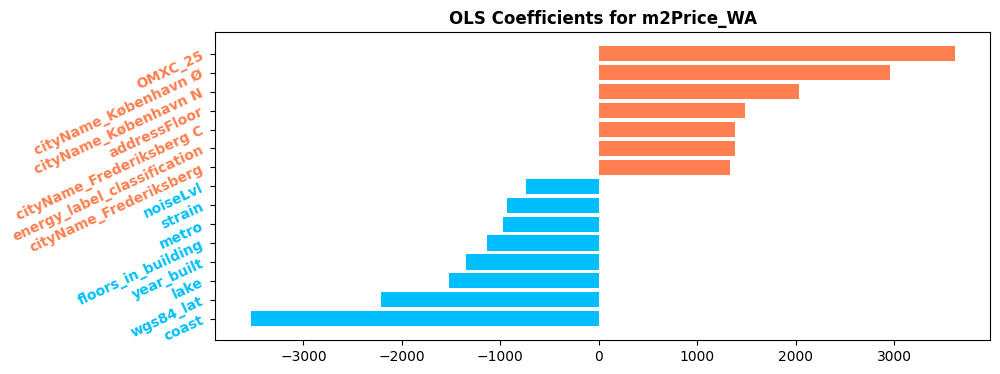

LOGTRANSFORMED : LOG(m2Price_WA)


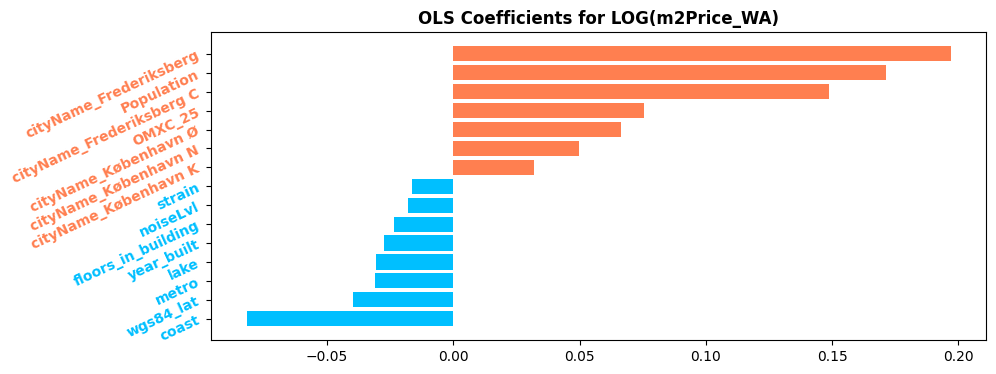

In [28]:
###################################
### MOST IMPORTANT COEFFICIENTS ###
###################################

Coefs_And_Plot(coefs_sold_price, 'sold_price', 'No')
Coefs_And_Plot(coefs_sold_price_ln, 'sold_price', 'Yes')

Coefs_And_Plot(coefs_m2Price, 'm2Price_WA', 'No')
Coefs_And_Plot(coefs_m2Price_ln, 'm2Price_WA', 'Yes')

In [29]:
##############################
########## p-values ##########
##############################


#Instead of calculate it in hand, we use the statsmodel to find out what the p-values is. 

def get_p_values(Coefs_, Xy_):

    #We use the traning sets as we did when we fittede our other OLS model
    X = Xy_.loc[Xy_['Data']=='Training data'].iloc[:,0:-2]
    y = Xy_.loc[Xy_['Data']=='Training data']['y']

    #We add a constant, because there is not by default in the statsmodel a intercept.
    X2 = sm.add_constant(X)
    #And now we use the statsmodel, where we fit the OLS on the same dataset, so we dont have to calculate our p-values manually.
    est = sm.OLS(y, X2).fit()
    #We save the p-values in a dataframe 
    pval = pd.DataFrame(est.pvalues, columns=['p_values'])
    #We round the decimal to 4 digits. 
    pval = pval.round(4)   
    #We then reset the index temporary, because we want to mak a merge later. So we now get the index names as a column, we can merge to.
    pval.reset_index(inplace=True)
    #We change the index name from const to our Intercept
    pval = pval.replace(['const'], 'Intercept') 

    #We take a copy of the coefficents dataset
    coef = Coefs_.copy()
    coef = pd.DataFrame(coef)
    #As the same reason as before we reset the index.
    coef.reset_index(inplace=True)
    #And now it is easy for us to merge. 
    coef_And_pval = coef.merge(pval, on='index')
    #We make a new column, with the  absolute values of the coeffocoents. 
    coef_And_pval['Coefficients_abs'] = np.abs(coef_And_pval['Coefficients'])
    
    

    
    
    #We set the index column back into the index, so we have our variable names there. 
    coef_And_pval = coef_And_pval.set_index('index')

    #We print out the first 10 variables of our new dataframe with the smallest coefficents, given the Absolute values
    #It is printed as latex code. 
    prin = coef_And_pval.sort_values(by=['Coefficients_abs'], ascending=False).head(9)
    prin = pd.concat([prin, coef_And_pval.sort_values(by=['Coefficients_abs'], ascending=False).tail(8)])
    #And then we drop the coefficents column.
    prin.drop(columns=['Coefficients_abs'],inplace=True)
    print(prin.to_latex(index=True))

    #And we then sort our new dataset, so the p-values is descending. Which we will return. 
    coef_And_pval.sort_values(by=['p_values'], inplace=True, ascending=False)
    return coef_And_pval





In [64]:
pd.set_option('display.max_rows', None)
pval_sold_price_ln = get_p_values(coefs_sold_price_ln, Xy_sold_price_ln)


\begin{tabular}{lrr}
\toprule
{} &  Coefficients &  p\_values \\
index                     &               &           \\
\midrule
Intercept                 &     15.087896 &    0.0000 \\
weighted\_area             &      0.250329 &    0.0000 \\
cityName\_Frederiksberg    &      0.191278 &    0.0000 \\
Population                &      0.151341 &    0.0000 \\
cityName\_Frederiksberg C  &      0.146936 &    0.0000 \\
num\_rooms                 &      0.138585 &    0.0000 \\
coast                     &     -0.093509 &    0.0000 \\
OMXC\_25                   &      0.075400 &    0.0000 \\
cityName\_København Ø      &      0.062647 &    0.0000 \\
carport\_area              &     -0.000507 &    0.6865 \\
Opp\_for\_balcony           &     -0.000487 &    0.6494 \\
ElPrice\_incl\_moms\_4000kWh &      0.000417 &    0.8989 \\
cityName\_Valby            &      0.000276 &    0.9514 \\
ForcedSalesOfProperty     &     -0.000257 &    0.8607 \\
cityName\_København SV     &      0.000233 &    0.9509 \\


C:\Users\Mtubo\AppData\Local\Temp\ipykernel_3540\1817075803.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(prin.to_latex(index=True))


In [31]:
pval_m2Price_ln = get_p_values(coefs_m2Price_ln, Xy_m2Price_ln)


\begin{tabular}{lrr}
\toprule
{} &  Coefficients &  p\_values \\
index                             &               &           \\
\midrule
Intercept                         &     10.656812 &    0.0000 \\
cityName\_Frederiksberg            &      0.197178 &    0.0000 \\
Population                        &      0.171463 &    0.0000 \\
cityName\_Frederiksberg C          &      0.148981 &    0.0000 \\
coast                             &     -0.081796 &    0.0000 \\
OMXC\_25                           &      0.075365 &    0.0000 \\
cityName\_København Ø              &      0.066532 &    0.0000 \\
cityName\_København N              &      0.049692 &    0.0000 \\
wgs84\_lat                         &     -0.039848 &    0.0000 \\
built\_in\_garage                   &     -0.001118 &    0.2263 \\
conservatory\_area                 &      0.001109 &    0.2297 \\
Rooftop\_Terrace                   &      0.001073 &    0.2302 \\
unemployedRate                    &      0.001038 &    0.6307 \\
librar

C:\Users\Mtubo\AppData\Local\Temp\ipykernel_3540\1817075803.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(prin.to_latex(index=True))


In [32]:
pval_sold_price_ln

,Coefficients,p_values,Coefficients_abs
index,,,
cityName_Valby,0.000276,0.9514,0.000276
cityName_København SV,0.000233,0.9509,0.000233
lot,0.000170,0.9367,0.000170
built_in_garage,-0.000138,0.9010,0.000138
ElPrice_incl_moms_4000kWh,0.000417,0.8989,0.000417
ForcedSalesOfProperty,-0.000257,0.8607,0.000257
carport_area,-0.000507,0.6865,0.000507
Opp_for_balcony,-0.000487,0.6494,0.000487
House_Animals,-0.001257,0.6120,0.001257


In [33]:

pval_m2Price_ln

,Coefficients,p_values,Coefficients_abs
index,,,
House_Animals,-0.000431,0.8353,0.000431
Opp_for_balcony,0.000226,0.8008,0.000226
unemployedRate,0.001038,0.6307,0.001038
library,0.000792,0.5867,0.000792
heating_code_Fjernvarme/blokvarme,-0.000641,0.4845,0.000641
publicbath,-0.001332,0.4349,0.001332
num_bathrooms,0.001201,0.3957,0.001201
ElPrice_incl_moms_4000kWh,-0.002423,0.3782,0.002423
BenzinPrice_incl_moms,0.002817,0.3523,0.002817


In [34]:
pd.reset_option('display.max_rows')

In [72]:
pval_sold_price_ln.loc[pval_sold_price_ln['p_values']>=0.05].sort_values('p_values')
#20 non-significant

,Coefficients,p_values,Coefficients_abs
index,,,
floodRisk,-0.002254,0.0505,0.002254
conservatory_area,0.001992,0.0712,0.001992
heating_code_Fjernvarme/blokvarme,-0.001948,0.0756,0.001948
built_in_outhouse_area,-0.001899,0.0778,0.001899
cityName_København S,0.013942,0.0944,0.013942
roofType_Tegl,0.002183,0.2187,0.002183
publicbath,0.002244,0.2713,0.002244
roofType_Fibercement herunder asbest,-0.001760,0.2941,0.001760
airport,-0.010123,0.3069,0.010123


In [71]:
pval_m2Price_ln.loc[pval_m2Price_ln['p_values']>=0.05].sort_values('p_values')
#20 non-significant

,Coefficients,p_values,Coefficients_abs
index,,,
airport,0.015709,0.0581,0.015709
outWallMaterialType_Mursten,0.002289,0.1214,0.002289
roadtrain,0.006199,0.1853,0.006199
built_in_garage,-0.001118,0.2263,0.001118
conservatory_area,0.001109,0.2297,0.001109
Rooftop_Terrace,0.001073,0.2302,0.001073
biggestParty_socialdemokratiet,-0.002565,0.2573,0.002565
lot,-0.001993,0.2658,0.001993
BenzinPrice_incl_moms,0.002817,0.3523,0.002817
